# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Asymmetric-Quadratic metrics

In this notebook, we solve Asymmetric-Quadratic eikonal equations on the CPU and the GPU, and check that they produce consistent results.

*Note on the numerical schemes*: The numerical schemes solved by the CPU and the GPU in the Asymmetric-Quadratic case are entirely different. The CPU version uses a causal semi-Lagrangian scheme, in two dimensions, and a causal Eulerian scheme in three dimensions, which is only approximately consistent. The GPU version uses a non-causal (yet monotone) Eulerian scheme, in any dimension.

In [41]:
large_instances = True # True favors the GPU code (CPU times may become a big long.)
strong_anisotropy = True # True favors the CPU code 

[**Summary**](Summary.ipynb) of volume GPU accelerated methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research.
The author would like to acknowledge fruitful informal discussions with L. Gayraud on the 
topic of GPU coding and optimization.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('AsymQuad_Repro','GPU'))

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

from agd.ExportedCode.Notebooks_GPU.Isotropic_Repro import RunCompare

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32)
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
Eikonal.dictIn.default_mode = 'gpu'

In [6]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunSmart,Metrics
    Eikonal,ad,cugen,Metrics = rreload([Eikonal,ad,cugen,Metrics],"../..")    
    Eikonal.dictIn.default_mode = 'gpu'

## 1. Two dimensions

In [88]:
n=2000 if large_instances else 200
asym = 4. if strong_anisotropy else 1.
hfmIn = Eikonal.dictIn({
    'model':'AsymmetricQuadratic2',
    'seed':[0.,0.],
    'exportValues':1,
    'factoringRadius':20,
    'count_updates':True,
#    'bound_active_blocks':True,
#    'traits':{'niter_i':16}
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn.SetUniformTips((6,6))
hfmIn['metric'] = Metrics.AsymQuad(cp.eye(2),cp.array([asym,0.]) ).rotate_by(cp.array(0.5))
X = hfmIn.Grid()

In [90]:
#gpuOut = hfmIn.Run()

 The CPU and gpu code produce identical similar results, despite the very distinct implementations.

In [46]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.01)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 3.532499313354492 seconds, and 653 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 2
Fast marching solver completed in 10.671 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Solver time (s). GPU : 3.532499313354492, CPU : 19.273. Device acceleration : 5.4559104731143435
Max |gpuValues-cpuValues| :  0.004501421632904901


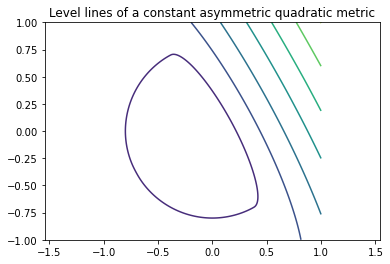

In [44]:
plt.title('Level lines of a constant asymmetric quadratic metric'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

The geodesics are straight lines, as expected for a constant metric.

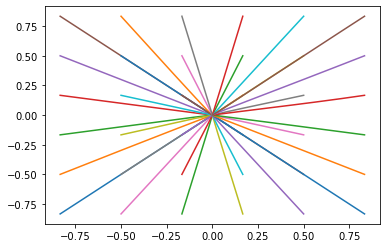

In [48]:
for geo in gpuOut['geodesics']: plt.plot(*geo)

The GPU acceleration depends on the strength of the anisotropy, on the instance size, and on the dimension.

Unfortunately, it is often modest. This is due to the very large number of updates applied to each block, often in excess of 300. This is presumably due to the non-causality of the scheme. Future work will be devoted to improving this situation.

In [91]:
nupdate = gpuOut['stats']['eikonal']['nupdate_o'].get()
np.mean(nupdate),np.max(nupdate)

(78.500626974175, 296)

The number of updates is increasing almost linearly in all directions, from the seed point. This is a strong hint that a mechanism for bounding the front width is needed.

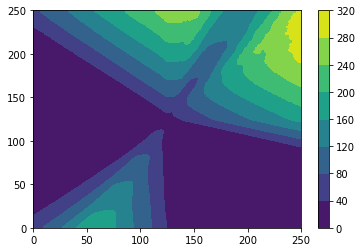

In [61]:
plt.contourf(gpuOut['stats']['eikonal']['nupdate_o']); plt.colorbar()

## 2. Three dimensions

In [92]:
n=200 if large_instances else 50
asym = 4. if strong_anisotropy else 1.
hfmIn = Eikonal.dictIn({
    'model':'AsymmetricQuadratic3',
    'seed':[0.,0.,0.],
    'exportValues':1,
#    'factoringRadius':20, # 3D cpu version does not support factoring
    'count_updates':True,
#    'bound_active_blocks':True,
#    'traits':{'niter_i':16}
})
hfmIn.SetRect([[-1,1],[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn.SetUniformTips((6,6,6))
hfmIn['metric'] = Metrics.AsymQuad(cp.eye(3),cp.array([asym,0.,0.]) ).rotate_by(cp.array(0.5),cp.array([1.,2.,3.]) )
X = hfmIn.Grid()

In [93]:
#gpuOut = hfmIn.Run()

In [84]:
gpuOut,cpuOut = RunCompare(hfmIn,check=False)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 8.050981998443604 seconds, and 210 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field eps defaults to 0.3
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 70.593 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 8.050981998443604, CPU : 111.24000000000001. Device acceleration : 13.816948047021427
Max |gpuValues-cpuValues| :  0.0715394439968915


Again, the number of GPU updates is higher than we would like it to be. The situation is not a bad as in two dimensions, nevertheless, because the domain is less wide.

In [87]:
nupdate = gpuOut['stats']['eikonal']['nupdate_o'].get()
np.mean(nupdate),np.max(nupdate)

(36.44849266119366, 133)